# Softmax Classification (with Cross-Entropy Loss)

In this exercise you will:

- Implement a fully-vectorized **loss function** for the Softmax classifier
- Implement the fully-vectorized expression for its **analytic gradient**
- **Check your implementation** with numerical gradient
- Use a validation set to **tune the learning rate and regularization** strength
- **Optimize** the loss function with **SGD**
- **Visualize** the final learned weights


In [1]:
import time
import random
import math
import numpy as np
from exercise_code.model_savers import save_softmax_classifier
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

To your convenience, we have taken care of all the input handling. Nevertheless, you should go through the following code line by line so that you understand the general preprocessing pipeline.
The whole datasat is loaded, then subdivided into a training, validation and test dataset (the last one is different from the final evaluation dataset on our server!).

Before proceeding you should *always* take a look at some samples of your dataset, which is already implemented for you. This way you can make sure that the data input/preprocessing has worked as intended and you can get a feeling for the dataset.

In [2]:
from exercise_code.data_utils import load_CIFAR10
# Load the raw CIFAR-10 data
cifar10_dir = 'datasets/'
X, y = load_CIFAR10(cifar10_dir)

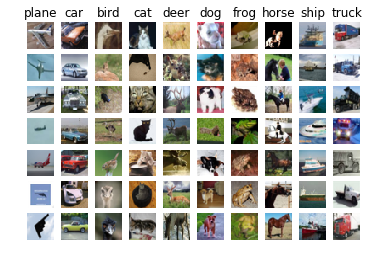

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y_hat, cls in enumerate(classes):
    idxs = np.flatnonzero(y == y_hat)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y_hat + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the data set;
# we can use this for development so our code runs faster.
num_training = 48000
num_validation = 1000
num_test = 1000
num_dev = 500

assert (num_training + num_validation + num_test) == 50000, 'You have not provided a valid data split.'

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X[mask]
y_train = y[mask]

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X[mask]
y_val = y[mask]

# We use a small subset of the training set as our test set.
mask = range(num_training + num_validation, num_training + num_validation + num_test)
X_test = X[mask]
y_test = y[mask]

# We will also make a development set, which is a small subset of
# the training set. This way the development cycle is faster.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (48000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64297917 135.92841667 132.4100625  130.0744375  135.3130625
 131.70479167 131.0373125  136.18741667 132.48804167 131.65420833]


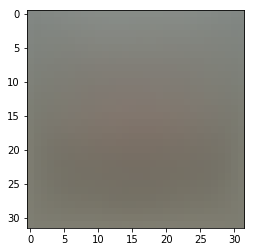

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our classifier
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(48000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## Softmax Classifier

In this section you will implement the essential elements of a softmax classifier. We will start with the cross-entropy loss and it's gradient with respect to the classifier's weights. We suggest that you first derive these expressions on paper.

### Naive Implementation
First implement a naive cross-entropy loss function with nested loops. Open the file `exercise_code/classifiers/softmax.py` and implement the loss of the softmax classifier into the `cross_entropoy_loss_naive` function.

Running this method might take a while...

In [14]:
from exercise_code.classifiers.softmax import cross_entropoy_loss_naive

# Generate a random weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = cross_entropoy_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.348857
sanity check: 2.302585


<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>Why do we expect our loss to be close to -log(0.1)? Explain briefly.</p>
    
    The weights are initialized with randomly (uniformly), so every class output should have roughly the same output (averaged over a batch). If every class has roughly the same output value our softmax will be 1/10 = 0.1 and the rest is just the NLL, therefore -log(0.1). 
</div>

Complete the implementation of the `cross_entropoy_loss_naive` function and implement a (naive) version of the gradient that uses nested loops. Use the following cell to check your results:

In [15]:
from exercise_code.gradient_check import grad_check_sparse
# We take a smaller dev set since the naive implementation takes quite some while
X_dev_small, y_dev_small = X_dev[:10], y_dev[:10]

loss, grad = cross_entropoy_loss_naive(W, X_dev_small, y_dev_small, 0.0)

# We use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
f = lambda w: cross_entropoy_loss_naive(w, X_dev_small, y_dev_small, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, num_checks=3)

# Again, running this might take a while!

numerical: 8.878465797201862 analytic: 8.878465779883054, relative error: 9.753266011125953e-10
numerical: 5.870652630757255 analytic: 5.870652031581237, relative error: 5.103146842415651e-08
numerical: -1.938598002215741 analytic: -1.938597876596194, relative error: 3.239958746300116e-08


In [16]:
# Do another gradient check with regularization
loss, grad = cross_entropoy_loss_naive(W, X_dev_small, y_dev_small, 1e2)
f = lambda w: cross_entropoy_loss_naive(w, X_dev_small, y_dev_small, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, num_checks=3)

numerical: -7.478365512647577 analytic: -7.464046104744185, relative error: 0.0009583063477334361
numerical: 2.2409200090445225 analytic: 2.222357414714995, relative error: 0.004158960460470744
numerical: 4.960114057528386 analytic: 4.9540635543598555, relative error: 0.0006102879538163308


### Vectorized Implementation
Now that we have a naive implementation of the cross-entropy loss and its gradient, implement a vectorized version in `cross_entropoy_loss_vectorized`.

The two versions should compute the same results, but the vectorized version should be much faster.

In [17]:
from exercise_code.classifiers.softmax import cross_entropoy_loss_vectorized

tic = time.time()
loss_naive, grad_naive = cross_entropoy_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = cross_entropoy_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# We use the Frobenius norm to compare the two versions of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.348857e+00 computed in 0.267318s
vectorized loss: 2.348857e+00 computed in 0.026950s
Loss difference: 0.000000
Gradient difference: 0.000000


<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>When you compute the softmax distribution, you are dividing by a sum of exponentials, i.e. potentially very large numbers, which can be numerically unstable. Do you see a way to avoid this problem?
</p>
    <p>(Hint: exploit properties of the exponential function to arrive at an expression that is mathematically the same, but numerically more stable)</p>
    The common way to do this is to just substract the maximum value of the input from every element in the input vector and then exponentiate. This avoids higher magnitues in the exponentials (at least to some degree). This can be easily shown to be exactly the same using some basic math.
</p>
</div>

### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to usw SGD to minimize the loss. In the file `exercise_code/classifiers/linear_classifier.py`, implement SGD in the `LinearClassifier.train` method and test it with the code below.

In [23]:
from exercise_code.classifiers.softmax import SoftmaxClassifier

# The SoftmaxClassifier class inherits from LinearClassifier
softmax = SoftmaxClassifier()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                          num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 1552.683592
iteration 100 / 1500: loss 569.051640
iteration 200 / 1500: loss 209.858230
iteration 300 / 1500: loss 78.158312
iteration 400 / 1500: loss 30.055569
iteration 500 / 1500: loss 12.305722
iteration 600 / 1500: loss 5.974322
iteration 700 / 1500: loss 3.499549
iteration 800 / 1500: loss 2.694817
iteration 900 / 1500: loss 2.354609
iteration 1000 / 1500: loss 2.232244
iteration 1100 / 1500: loss 2.156876
iteration 1200 / 1500: loss 2.126830
iteration 1300 / 1500: loss 2.194408
iteration 1400 / 1500: loss 2.129891
That took 17.029047s


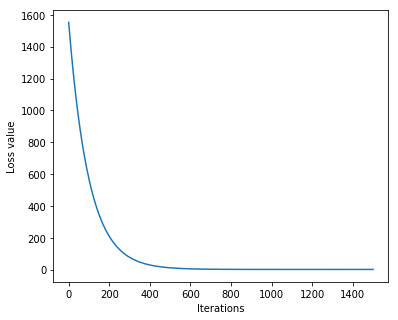

In [24]:
# A useful debugging strategy is to plot the loss as a function of iterations:
plt.figure(figsize=(6,5))
plt.plot(loss_hist)
plt.xlabel('Iterations')
plt.ylabel('Loss value')
plt.show()

Write the `LinearClassifier.predict` method and evaluate the performance on both the training and validation set:

In [31]:
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.335188
validation accuracy: 0.335000


### Training your Softmax Classifier
Use the validation set to tune hyperparameters (regularization strength and learning rate). You should experiment with different ranges for the learning rates and regularization strengths; if you are careful you should be able to get a classification accuracy of over 0.35 on the validation set. Implement the `softmax_hyperparameter_tuning` function in `exercise_code/classifiers/softmax.py`.

In [32]:
from exercise_code.classifiers.softmax import SoftmaxClassifier, softmax_hyperparameter_tuning

best_softmax, results, all_classifiers = softmax_hyperparameter_tuning(X_train, y_train, X_val, y_val)

iteration 0 / 1500: loss 769.312789
iteration 100 / 1500: loss 465.609920
iteration 200 / 1500: loss 282.022546
iteration 300 / 1500: loss 171.443602
iteration 400 / 1500: loss 104.627460
iteration 500 / 1500: loss 63.973008
iteration 600 / 1500: loss 39.619990
iteration 700 / 1500: loss 24.799391
iteration 800 / 1500: loss 15.864289
iteration 900 / 1500: loss 10.496363
iteration 1000 / 1500: loss 7.155847
iteration 1100 / 1500: loss 5.081842
iteration 1200 / 1500: loss 3.882983
iteration 1300 / 1500: loss 3.218100
iteration 1400 / 1500: loss 2.853914
iteration 0 / 1500: loss 1560.483382
iteration 100 / 1500: loss 571.903464
iteration 200 / 1500: loss 210.573025
iteration 300 / 1500: loss 78.499986
iteration 400 / 1500: loss 30.087611
iteration 500 / 1500: loss 12.389367
iteration 600 / 1500: loss 5.929878
iteration 700 / 1500: loss 3.529790
iteration 800 / 1500: loss 2.746732
iteration 900 / 1500: loss 2.334979
iteration 1000 / 1500: loss 2.204519
iteration 1100 / 1500: loss 2.185717


iteration 1300 / 1500: loss 2.417061
iteration 1400 / 1500: loss 2.365411
iteration 0 / 1500: loss 1560.379514
iteration 100 / 1500: loss 2.840373
iteration 200 / 1500: loss 2.980911
iteration 300 / 1500: loss 3.342663
iteration 400 / 1500: loss 2.549065
iteration 500 / 1500: loss 2.897022
iteration 600 / 1500: loss 2.661854
iteration 700 / 1500: loss 2.732020
iteration 800 / 1500: loss 3.022862
iteration 900 / 1500: loss 3.259758
iteration 1000 / 1500: loss 2.357203
iteration 1100 / 1500: loss 2.691501
iteration 1200 / 1500: loss 2.854789
iteration 1300 / 1500: loss 2.782008
iteration 1400 / 1500: loss 3.064126
iteration 0 / 1500: loss 35.705820
iteration 100 / 1500: loss 12.934865
iteration 200 / 1500: loss 5.683078
iteration 300 / 1500: loss 3.420017
iteration 400 / 1500: loss 2.611653
iteration 500 / 1500: loss 2.197178
iteration 600 / 1500: loss 2.029058
iteration 700 / 1500: loss 2.019398
iteration 800 / 1500: loss 2.037720
iteration 900 / 1500: loss 1.790902
iteration 1000 / 150

/Users/magnusja/Documents/code/i2dl/exercise_1/exercise_code/classifiers/softmax.py:92: RuntimeWarning: divide by zero encountered in log
  loss = -np.log(exp_this[np.arange(num_train), y] / exp_sum)
/Users/magnusja/Documents/code/i2dl/exercise_1/exercise_code/classifiers/softmax.py:89: RuntimeWarning: overflow encountered in exp
  exp_this = np.exp(log_probs)
/Users/magnusja/Documents/code/i2dl/exercise_1/exercise_code/classifiers/softmax.py:92: RuntimeWarning: invalid value encountered in true_divide
  loss = -np.log(exp_this[np.arange(num_train), y] / exp_sum)
/Users/magnusja/Documents/code/i2dl/exercise_1/exercise_code/classifiers/softmax.py:98: RuntimeWarning: invalid value encountered in true_divide
  grad = exp_this / exp_sum[:, np.newaxis]


iteration 100 / 1500: loss nan
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 35.909181
iteration 100 / 1500: loss 20.810355
iteration 200 / 1500: loss 27.702679
iteration 300 / 1500: loss 26.337202
iteration 400 / 1500: loss 12.837289
iteration 500 / 1500: loss 29.326153
iteration 600 / 1500: loss 19.834042
iteration 700 / 1500: loss 15.275921
iteration 800 / 1500: loss 22.060112
iteration 900 / 1500: loss 26.485169
iteration 1000 / 1500: loss 19.393923
iteration 1100 / 1500: loss 19.108871
iteration 1200 / 1500: loss 16.725508
iteration 1300 / 1500: loss 27.209787
iteration 1400 / 1500: loss 15.242414
ite

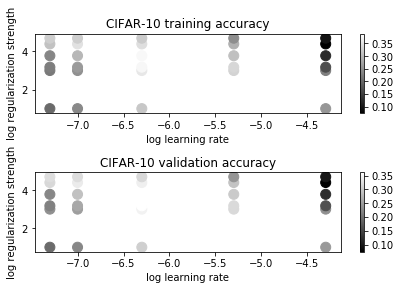

In [33]:
# Visualize the validation results
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')

plt.tight_layout()
plt.show()

In [34]:
# if you want to take a look at the other classifiers assign them to best_softmax here
sorted_classifiers = sorted(all_classifiers, key=lambda x : x[1])
best_softmax = sorted_classifiers[-1][0]

TypeError: 'SoftmaxClassifier' object does not support indexing

In [35]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.387000


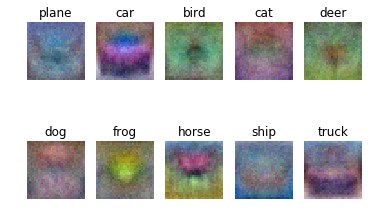

In [36]:
# Visualize the learned weights for each class
#best_softmax = sorted_classifiers[idx][0]
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)

  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>Describe what your visualized Softmax weights look like.</p>
    
    I can clearly see that the classifier reacts to different colors, e.g. frog vs cars vs deer. Also you can see where usually the object is in the image, e.g. frog and deer. The same applies for the horse. I feel like I can even see that sometimes the head of the horse is left and sometimes right. THe horse is proabably the example where you can even see the overall structure. It is not that clear for other instance. For the car I feel like I can see the upper and lower parts as well as some wheels.
</div>

## Save the model

When you are satisfied with your training, save the model for submission. Your final score is computed by `accuracy * 100`. In order to pass this exercise, you have to achieve a score higher than __35__.

<div class="alert alert-danger">
    <h3>Warning</h3>
    <p>You might get an error like this:</p>
    <p>PicklingError: Can't pickle `<class 'exercise_code.classifiers.softmax.SoftmaxClassifier'>`: it's not the same object as exercise_code.classifiers.softmax.SoftmaxClassifier</p>
    <p>The reason is that we are using autoreload and working on this class during the notebook session. If you get this error simply restart the kernel and rerun the whole script (Kernel -> Restart & Run All) or only the important cells for generating your model.</p>
</div>

In [37]:
from exercise_code.model_savers import save_softmax_classifier
from exercise_code.classifiers.softmax import SoftmaxClassifier

save_softmax_classifier(best_softmax)